In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import os
import time

In [2]:
# Set visibible GPU
gpu_num: int = 2
os.environ['CUDA_VISIBLE_DEVICES']=f'{gpu_num}'

In [3]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 1 GPUs.  Setting memory growth = True.


In [4]:
# MSE Imports
from asteroid_element import load_ast_elt
from asteroid_search import load_fitted_elts, load_ztf_hits, append_fitted_elt, append_ztf_hit, file_name_model
from candidate_element import asteroid_elts, random_elts, elts_add_mixture_params, elts_add_H
from random_elements import load_best_random_elts, make_ztf_ast
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [5]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [6]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Best Fitted Elements from Random Search

In [26]:
known_ast = False
min_hits = 8
max_res: float = 20.0

In [27]:
elts_search = load_fitted_elts(known_ast=known_ast, min_hits=min_hits)
is_good = elts_search.R_sec < max_res
elts_good = elts_search[is_good]

In [28]:
num_elts: int = elts_good.shape[0]
print(f'found {num_elts} good elements with at least {min_hits} hits and R_sec < {max_res} arc seconds.')

found 9 good elements with at least 8 hits and R_sec < 20.0 arc seconds.


## Load ZTF Data and Batch of Orbital Elements

In [29]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [30]:
# Parameters to build random orbital elements and ztf_ast
random_seed = 0
batch_size_init = 1024
batch_size = 64
thresh_deg = 2.0

In [31]:
# Load ztf nearest asteroid data for known asteroids
ztf_ast = make_ztf_ast(known_ast=known_ast)

In [32]:
# Review ztf_ast
ztf_ast

,ztf_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz,is_hit
0,0,b'ZTF18acebhfp',676397301515010013,14490,58430.397303,41.357345,58.879488,0.387942,0.653853,0.649598,18.946699,0.865682,1208789,0.005029,41.396388,58.592038,0.390926,0.655662,0.645976,False
1,1,b'ZTF18abodmwk',596403415715010014,5831,58350.403414,30.969721,65.305308,0.358224,0.558644,0.748059,19.010401,0.855504,1227812,0.024428,33.729101,64.536183,0.357570,0.578168,0.733393,False
2,2,b'ZTF18abodmwk',626428345715010011,10614,58380.428345,30.969705,65.305294,0.358224,0.558644,0.748059,18.935900,0.855504,1169677,0.015510,29.207596,64.817653,0.371401,0.550472,0.747691,False
3,3,b'ZTF18abodmwk',630507595715015045,11250,58384.507593,30.969940,65.305305,0.358223,0.558645,0.748059,19.260401,0.855504,1251951,0.012386,30.227911,65.945543,0.352183,0.551505,0.756181,False
4,4,b'ZTF18abodmwk',618384965715010022,9040,58372.384965,30.969643,65.305179,0.358226,0.558644,0.748058,19.220200,0.855504,1246591,0.025343,34.169666,64.771024,0.352659,0.579473,0.734740,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5697957,5697957,b'ZTF20aareruw',1151532523515015015,97109,58905.532523,253.007910,55.485537,-0.165587,-0.169403,0.971537,19.192400,0.608023,1102168,0.036944,253.707834,53.408139,-0.167230,-0.205583,0.964246,False
5697958,5697958,b'ZTF20aarerwx',1151533002615015009,97110,58905.533009,232.886408,53.509617,-0.358833,-0.115301,0.926253,19.687099,0.559474,1028157,0.084402,224.967815,54.919912,-0.406617,-0.047125,0.912382,False
5697959,5697959,b'ZTF20aarerww',1151533002115010003,97110,58905.533009,236.167899,54.618457,-0.322375,-0.116973,0.939357,19.957001,0.392662,539940,0.052254,240.693936,56.155104,-0.272611,-0.115218,0.955200,False
5697960,5697960,b'ZTF20aarervr',1151526063515015015,97098,58905.526065,286.235286,33.876902,0.232120,-0.509626,0.828494,19.049299,0.517241,1246304,0.014054,285.998189,34.657915,0.226704,-0.499251,0.836274,False


In [33]:
# Best random elements
elts_random = load_best_random_elts(
    random_seed=random_seed, known_ast=known_ast, 
    batch_size_init=batch_size_init, batch_size=batch_size, thresh_deg=thresh_deg)

Loaded random elements in ../data/ztf_elt/random_elts_miss_seed_000_size_64_of_1024_thresh_7200.h5.


In [34]:
# Choose best fitted elements from asteroid search
cols_elts = ['element_id', 'a', 'e', 'f', 'inc', 'Omega', 'omega', 'epoch',]
elts = elts_good[cols_elts]

In [35]:
elts.reset_index(inplace=True, drop=True)

In [36]:
# elts = elts_random

In [37]:
# Review best random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch
0,170789,2.735330,0.152867,-3.443415,0.403704,6.038029,3.016818,58600.0
1,178421,3.159712,0.088905,-0.463039,0.153618,2.668798,4.773842,58600.0
2,44117,2.935864,0.187419,-3.122138,0.124515,3.166528,1.230836,58600.0
3,3308,3.026904,0.119945,4.818909,0.129432,3.903342,4.525802,58600.0
4,45801,2.754677,0.047293,-1.949476,0.118126,3.139070,5.767782,58600.0
5,113970,2.897023,0.068932,4.450756,0.209250,5.663728,3.868474,58600.0
6,50775,2.374712,0.100280,2.995417,0.165483,4.280114,5.955170,58600.0
7,96507,2.820178,0.069025,-2.630978,0.080228,2.221972,0.960994,58600.0
8,191915,2.315446,0.192885,-4.122024,0.057156,2.130249,2.865086,58600.0


## Batches of ZTF Data Near Initial Candidate Elements

In [38]:
# Arguments to make_ztf_batch
near_ast = False
regenerate = False

In [39]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, ztf=ztf_ast, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [40]:
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,mag_app,ux,...,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit,is_match
0,213373,3308,b'ZTF18abvpnre',892441290115010007,33983,58646.441296,353.313929,-12.174124,18.748800,0.970863,...,0.975502,-0.183442,-0.121432,2.949171,0.027608,5694.812384,0.999619,6.256196e-01,False,False
1,220140,3308,b'ZTF18abtpdzg',897475553515015001,34730,58651.475556,354.565776,-8.964458,17.382900,0.983346,...,0.977896,-0.172234,-0.118550,2.879101,0.028108,5797.787969,0.999605,6.484480e-01,False,False
2,240776,3308,b'ZTF18abtpdzg',916439883515015003,37324,58670.439884,354.565806,-8.964600,17.605200,0.983345,...,0.983343,-0.147816,-0.105767,2.621743,0.000013,2.639231,1.000000,1.343797e-07,False,False
3,240821,3308,b'ZTF18abtpdzg',916440334615015002,37325,58670.440336,354.565888,-8.964426,17.601101,0.983346,...,0.983343,-0.147815,-0.105766,2.621737,0.000016,3.215843,1.000000,1.995119e-07,False,False
4,240958,3308,b'ZTF18abtpdzg',916462603515015003,37362,58670.462604,354.565787,-8.964429,16.858500,0.983346,...,0.983347,-0.147807,-0.105749,2.621445,0.000005,0.977124,1.000000,1.841953e-08,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8652,5589170,191915,b'ZTF20aaqjsro',1149169821415015017,95796,58903.169826,94.973528,22.740897,19.265100,-0.079956,...,-0.070572,0.997428,-0.012548,2.135819,0.009568,1973.643884,0.999954,7.514730e-02,False,False
8653,5589471,191915,b'ZTF18aajvvpb',1149169375715010023,95795,58903.169375,94.073949,22.257472,19.334101,-0.065751,...,-0.070572,0.997428,-0.012548,2.135814,0.008624,1778.821913,0.999963,6.104377e-02,False,False
8654,5589778,191915,b'ZTF19abtsqmn',1149169375715010008,95795,58903.169375,94.436586,22.583826,18.624399,-0.071424,...,-0.070572,0.997428,-0.012548,2.135814,0.001541,317.770700,0.999999,1.948080e-03,False,False
8655,5612085,191915,b'ZTF20aaqmzff',1149244821315015002,95892,58903.244826,95.232064,23.930691,20.302700,-0.083351,...,-0.070567,0.997428,-0.012525,2.136718,0.025997,5362.514167,0.999662,5.547426e-01,False,False


In [41]:
# Score by element
score_by_elt = ztf_score_by_elt(ztf_elt)

In [42]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [43]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, thresh_deg=thresh_deg, R_deg=R_deg)

In [44]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [45]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Random Elements')

ZTF Element Dataframe Random Elements:
                  Total     (Per Batch)
Observations   :     8657   (      962)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     199.07
Sqrt(batch_obs):      31.01
Mean t_score   :       6.66


In [46]:
# Review random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_hits,R,thresh_s,H,sigma_mag
0,170789,2.735330,0.152867,-3.443415,0.403704,6.038029,3.016818,58600.0,10,0.008727,0.034905,16.5,4.0
1,178421,3.159712,0.088905,-0.463039,0.153618,2.668798,4.773842,58600.0,10,0.008727,0.034905,16.5,4.0
2,44117,2.935864,0.187419,-3.122138,0.124515,3.166528,1.230836,58600.0,10,0.008727,0.034905,16.5,4.0
3,3308,3.026904,0.119945,4.818909,0.129432,3.903342,4.525802,58600.0,10,0.008727,0.034905,16.5,4.0
4,45801,2.754677,0.047293,-1.949476,0.118126,3.139070,5.767782,58600.0,10,0.008727,0.034905,16.5,4.0
5,113970,2.897023,0.068932,4.450756,0.209250,5.663728,3.868474,58600.0,10,0.008727,0.034905,16.5,4.0
6,50775,2.374712,0.100280,2.995417,0.165483,4.280114,5.955170,58600.0,10,0.008727,0.034905,16.5,4.0
7,96507,2.820178,0.069025,-2.630978,0.080228,2.221972,0.960994,58600.0,10,0.008727,0.034905,16.5,4.0
8,191915,2.315446,0.192885,-4.122024,0.057156,2.130249,2.865086,58600.0,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [47]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [48]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0

In [49]:
# Build asteroid search model
model = AsteroidSearchModel(
            elts=elts, 
            ztf_elt=ztf_elt, 
            site_name=site_name, 
            thresh_deg=thresh_deg, 
            # file_name=f'candidate_elt_rand_known_{random_seed:04d}.h5',
            file_name=f'elts_search_unknown_ast.h5',
            name='model')

In [50]:
# Report before training starts
model.report()


Good elements (hits >= 5):   9.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:     1.54  :   8.67 :  1796.41 :  7200.00
Mean Bad :      nan  :    nan :      nan :      nan
Mean     :     1.54  :   8.67 :  1796.41 :  7200.00
Median   :     1.29  :   8.00 :  1796.41 :  7200.00
GeoMean  :     1.48  :   8.63 :  1796.41 :  7201.00
Min      :     0.41  :   8.00 :  1796.41 :  7200.00
Max      :     3.79  :  10.00 :  1796.41 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


## Automated Training with Sieve Method

In [80]:
# model.sieve(nearest_ast=True)

In [ ]:
# model.load()

In [81]:
model.report()


Good elements (hits >= 5):   9.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:    57.57  :   9.11 :     5.72 :   393.61
Mean Bad :      nan  :    nan :      nan :      nan
Mean     :    57.57  :   9.11 :     5.72 :   393.61
Median   :    60.58  :   9.00 :     4.32 :   350.23
GeoMean  :    56.94  :   9.05 :     5.36 :   375.17
Min      :    38.84  :   8.00 :     3.77 :   262.25
Max      :    68.72  :  11.00 :     9.71 :   809.80
Trained for 7232 batches over 113 epochs and 40 episodes (elapsed time 241 seconds).


## Filter Down to Only Good Elements

In [82]:
elts_good = model.candidates_df()

In [ ]:
# is_good = (elts_polished.hits >= min_hits) & (elts_polished.R_sec < max_res)

In [ ]:
# elts_polished[is_good]

In [91]:
cols = ['element_id', 'a', 'e', 'inc', 'Omega', 'omega', 'f', 'epoch', 'num_hits', 'R_sec', 'thresh_sec', 'num_rows_close', 'log_like']

In [92]:
elts_good[cols].sort_values('log_like', ascending=False)

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R_sec,thresh_sec,num_rows_close,log_like
1,178421,3.160327,0.089064,0.153620,2.668766,4.773995,-0.463213,58600.0,10.996569,3.773662,350.229950,15.0,68.716019
3,3308,3.026962,0.119945,0.129409,3.903006,4.525979,4.819063,58600.0,9.996422,3.821569,351.971649,14.0,63.716438
2,44117,2.935863,0.187419,0.124516,3.166528,1.230836,-3.122138,58600.0,9.994445,5.225097,357.466431,16.0,61.298466
0,170789,2.735335,0.152867,0.403704,6.038029,3.016815,-3.443415,58600.0,9.996418,7.083936,347.111053,13.0,60.860794
5,113970,2.897024,0.068932,0.209250,5.663728,3.868474,4.450756,58600.0,7.999145,3.958026,348.778046,9.0,60.584415
4,45801,2.754677,0.047293,0.118126,3.139070,5.767782,-1.949476,58600.0,8.996888,4.321019,326.387482,14.0,56.090981
6,50775,2.374712,0.100280,0.165483,4.280114,5.955170,2.995417,58600.0,9.948814,9.705722,809.804260,29.0,55.641151
7,96507,2.820351,0.068964,0.080233,2.222034,0.960931,-2.630966,58600.0,8.821539,3.905472,262.245087,12.0,52.416988
8,191915,2.315446,0.192885,0.057156,2.130249,2.865086,-4.122024,58600.0,7.982198,9.668445,388.469055,21.0,38.837540


## ZTF Hits of Good elements

In [100]:
ztf_hits = model.calc_ztf_hits()

In [101]:
cols_hit = ['element_id','ObjectID', 'mjd', 'ra', 'dec', 'mag_app', 's_sec']

In [105]:
mask = (ztf_hits.element_id == 178421)

In [107]:
ztf_hits.loc[ztf_hits.element_id == 178421, cols_hit]

,element_id,ObjectID,mjd,ra,dec,mag_app,s_sec
63,178421,b'ZTF18aboluox',58430.166620,346.704046,-10.675142,15.787200,1.260372
64,178421,b'ZTF18aboluox',58430.170313,346.704079,-10.675160,15.800000,0.982009
65,178421,b'ZTF18aboluox',58430.166620,346.704001,-10.675028,15.587700,1.699850
66,178421,b'ZTF18aboluox',58430.170313,346.704073,-10.675099,15.654600,1.175734
67,178421,b'ZTF18acewaex',58863.138472,67.229666,17.295098,19.328100,6.219038
68,178421,b'ZTF18acewaex',58863.138472,67.229789,17.295055,19.343500,5.789846
69,178421,b'ZTF18acewaex',58863.152465,67.229835,17.295083,19.283501,2.389730
70,178421,b'ZTF18acewaex',58863.152465,67.229783,17.295077,19.263100,2.392794


In [108]:
ztf_hits.loc[ztf_hits.element_id == 3308, cols_hit]

,element_id,ObjectID,mjd,ra,dec,mag_app,s_sec
0,3308,b'ZTF18abtpdzg',58670.439884,354.565806,-8.964600,17.605200,3.286346
1,3308,b'ZTF18abtpdzg',58670.440336,354.565888,-8.964426,17.601101,3.888707
2,3308,b'ZTF18abtpdzg',58670.462604,354.565787,-8.964429,16.858500,0.697156
3,3308,b'ZTF18abtpdzg',58670.463056,354.565909,-8.964536,17.128700,1.329765
4,3308,b'ZTF18abtpdzg',58670.462604,354.565824,-8.964445,17.092899,0.837276
5,3308,b'ZTF18abtpdzg',58670.463056,354.565809,-8.964412,16.658600,0.769468
6,3308,b'ZTF18abspkzw',58863.110058,346.642277,1.047679,16.541800,8.282505
7,3308,b'ZTF18abspkzw',58863.109606,346.642261,1.047839,16.946899,7.604068


In [112]:
# ztf_hits.loc[ztf_hits.element_id == 44117, cols_hit]

In [111]:
ztf_hits.loc[ztf_hits.element_id == 170789, cols_hit]

,element_id,ObjectID,mjd,ra,dec,mag_app,s_sec
55,170789,b'ZTF17aaaqwwg',58903.113588,84.725827,15.284655,19.437901,7.917067
56,170789,b'ZTF17aaaqwwg',58903.116806,84.725856,15.284678,19.699699,7.043546
57,170789,b'ZTF17aaaqwwg',58903.129097,84.725897,15.284685,20.146000,3.737848
58,170789,b'ZTF17aaaqwwg',58903.126840,84.725899,15.284678,19.689501,4.333303
59,170789,b'ZTF17aaaqwwg',58903.128194,84.725824,15.284668,19.916201,3.767049
60,170789,b'ZTF17aaaqwwg',58903.149248,84.726023,15.284693,19.143600,3.802050
61,170789,b'ZTF17aaaqwwg',58903.149699,84.725870,15.284728,19.707399,4.209481
62,170789,b'ZTF17aaaqwwg',58903.151053,84.725889,15.284665,19.904301,4.672150


In [113]:
ztf_hits.loc[ztf_hits.element_id == 113970, cols_hit]

,element_id,ObjectID,mjd,ra,dec,mag_app,s_sec
47,113970,b'ZTF17aaaslvs',58486.116713,35.373320,30.023565,18.058399,0.557415
48,113970,b'ZTF17aaaslvs',58486.117176,35.373034,30.023577,18.141600,0.392949
49,113970,b'ZTF20aanpmwr',58894.255776,143.283628,15.236996,19.132200,5.945589
50,113970,b'ZTF20aanqazy',58894.270012,143.279788,15.236326,19.267300,3.207955
51,113970,b'ZTF20aanrbcr',58894.291319,143.274076,15.235425,19.411800,0.849829
52,113970,b'ZTF20aanrflv',58894.298391,143.272204,15.235059,19.931101,2.168277
53,113970,b'ZTF20aanrflv',58894.297465,143.272443,15.235150,19.737101,1.826000
54,113970,b'ZTF20aanrsnw',58894.312373,143.268412,15.234461,20.087999,4.565091


In [114]:
ztf_hits.loc[ztf_hits.element_id == 45801, cols_hit]

,element_id,ObjectID,mjd,ra,dec,mag_app,s_sec
19,45801,b'ZTF17aadmibo',58534.127813,47.009013,11.179460,17.146601,0.959611
20,45801,b'ZTF17aadmibo',58534.127350,47.009206,11.179696,17.139999,1.431435
21,45801,b'ZTF19acvrose',58812.437720,116.913738,12.251436,19.568300,4.714124
22,45801,b'ZTF18aaaweau',58899.189803,103.133095,14.445428,17.902100,5.264922
23,45801,b'ZTF18aaaweau',58899.189803,103.133104,14.445456,17.550800,5.286260
24,45801,b'ZTF18aaaweau',58899.189803,103.133093,14.445428,17.789000,5.270391
25,45801,b'ZTF18aaaweau',58899.190706,103.133005,14.445566,17.205000,5.467746
26,45801,b'ZTF18aaaweau',58899.208287,103.133007,14.445438,17.782801,1.053170
27,45801,b'ZTF18aaaweau',58899.233461,103.133107,14.445611,16.757299,9.436963
28,45801,b'ZTF18aaaweau',58899.233461,103.133140,14.445582,17.017500,9.587748


In [117]:
# ztf_hits.loc[ztf_hits.element_id == 50775, cols_hit]

In [118]:
ztf_hits.loc[ztf_hits.element_id == 96507, cols_hit]

,element_id,ObjectID,mjd,ra,dec,mag_app,s_sec
38,96507,b'ZTF17aaawxhz',58378.317801,353.652727,-1.535984,16.569099,2.547043
39,96507,b'ZTF17aaaqwwg',58903.113588,84.725827,15.284655,19.437901,7.174352
40,96507,b'ZTF17aaaqwwg',58903.116806,84.725856,15.284678,19.699699,6.046500
41,96507,b'ZTF17aaaqwwg',58903.129097,84.725897,15.284685,20.146000,1.389077
42,96507,b'ZTF17aaaqwwg',58903.126840,84.725899,15.284678,19.689501,2.259592
43,96507,b'ZTF17aaaqwwg',58903.128194,84.725824,15.284668,19.916201,1.503983
44,96507,b'ZTF17aaaqwwg',58903.149248,84.726023,15.284693,19.143600,6.090673
45,96507,b'ZTF17aaaqwwg',58903.149699,84.725870,15.284728,19.707399,6.646546
46,96507,b'ZTF17aaaqwwg',58903.151053,84.725889,15.284665,19.904301,7.236228


In [119]:
ztf_hits.loc[ztf_hits.element_id == 191915, cols_hit]

,element_id,ObjectID,mjd,ra,dec,mag_app,s_sec
71,191915,b'ZTF18abtxtgd',58430.170313,341.181109,-12.234676,19.693501,0.036218
72,191915,b'ZTF18abtxtgd',58430.166620,341.181092,-12.234595,19.260099,2.621655
73,191915,b'ZTF19abtsqmn',58899.139884,94.436593,22.583914,18.914301,6.521414
74,191915,b'ZTF19abtsqmn',58899.140336,94.436579,22.583982,18.900700,6.623162
75,191915,b'ZTF19abtsqmn',58899.192569,94.436720,22.583899,19.819700,0.946245
76,191915,b'ZTF19abtsqmn',58899.222442,94.436672,22.583855,19.873501,4.829147
77,191915,b'ZTF19abtsqmn',58899.220162,94.436545,22.583886,20.234699,4.129297
78,191915,b'ZTF19abtsqmn',58899.220613,94.436587,22.583902,20.670900,4.263810


## Review Results Graphically

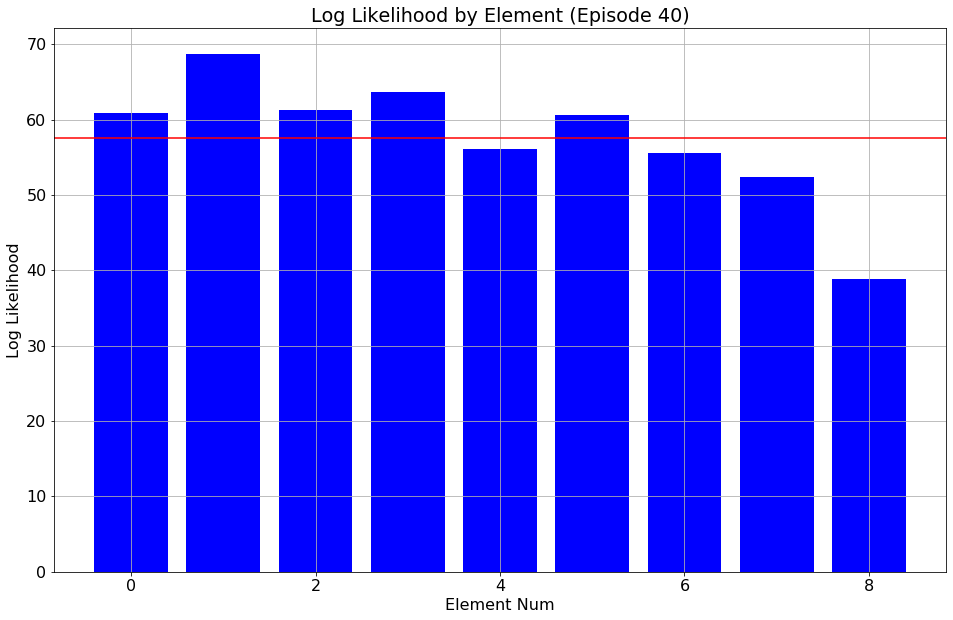

In [52]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

In [54]:
fig.savefig('../figs/search_unknown/log_like.png', bbox_inches='tight')

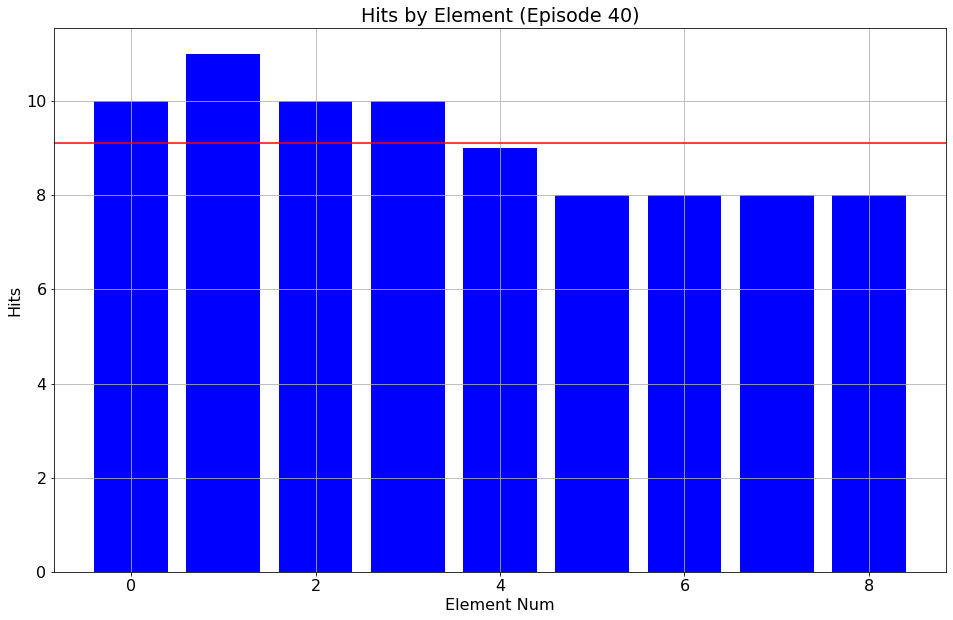

In [55]:
# Bar chart: hits
fig, ax = model.plot_bar('hits', sorted=False)

In [56]:
fig.savefig('../figs/search_unknown/hits.png', bbox_inches='tight')

In [57]:
# # Bar chart: resolution
# fig, ax = model.plot_bar('log_R', sorted=False)

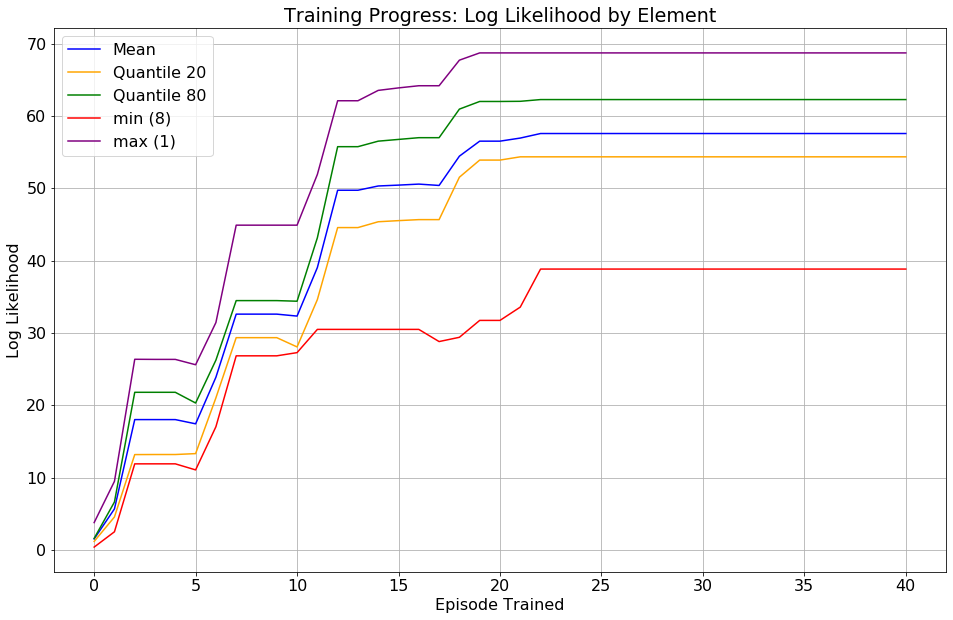

In [58]:
# Learning curve: log likelihood
fig, ax = model.plot_hist('log_like', 'episode')

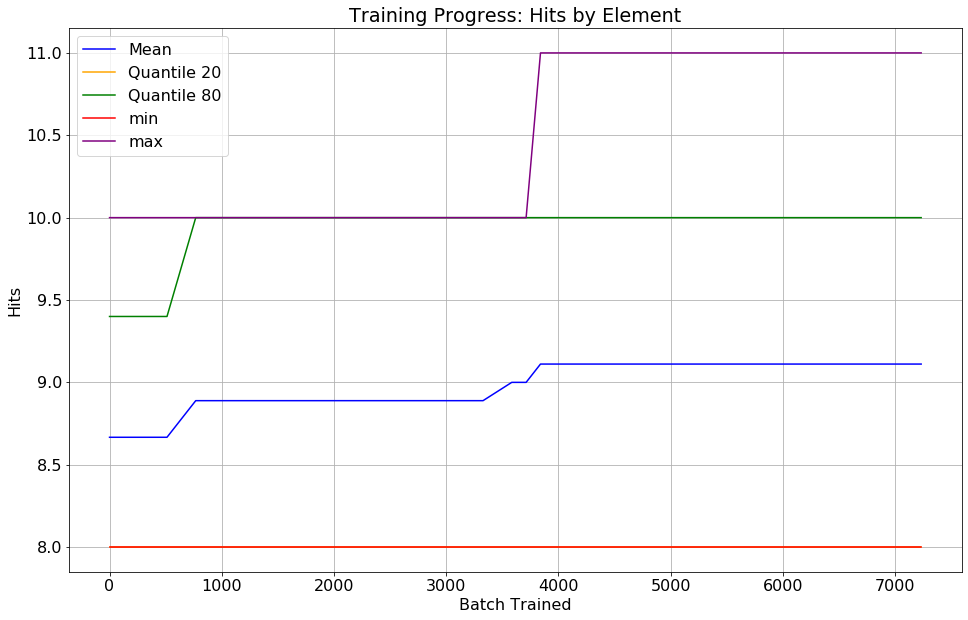

In [59]:
# Learning curve: hits
fig, ax = model.plot_hist('hits')

## Distance vs. Nearest Asteroid for Fitted Elements

In [60]:
# Find nearest asteroid to fitted elements - search on Cartesian distance
elts_fit, elts_near = model.nearest_ast(search_type='cart')

In [61]:
elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_deg,thresh_sec,log_like,hits,num_rows_close,H,sigma_mag,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,170789,2.735335,0.152867,0.403704,6.038029,3.016815,-3.443415,58600.0,9.996418,0.000034,...,0.096420,347.111053,60.860794,10.0,13.0,16.500002,1.0,1047744,0.006676,1.448192
1,178421,3.160327,0.089064,0.153620,2.668766,4.773995,-0.463213,58600.0,10.996569,0.000018,...,0.097286,350.229950,68.716019,11.0,15.0,16.500002,1.0,376024,0.002499,0.700349
2,44117,2.935863,0.187419,0.124516,3.166528,1.230836,-3.122138,58600.0,9.994445,0.000025,...,0.099296,357.466431,61.298466,10.0,16.0,16.500002,1.0,25765,0.007396,2.423578
3,3308,3.026962,0.119945,0.129409,3.903006,4.525979,4.819063,58600.0,9.996422,0.000019,...,0.097770,351.971649,63.716438,10.0,14.0,16.500002,1.0,201280,0.004529,1.025371
4,45801,2.754677,0.047293,0.118126,3.139070,5.767782,-1.949476,58600.0,8.996888,0.000021,...,0.090663,326.387482,56.090973,9.0,14.0,16.500002,1.0,1206761,0.003413,1.622976
5,113970,2.897024,0.068932,0.209250,5.663728,3.868474,4.450756,58600.0,7.999145,0.000019,...,0.096883,348.778046,60.584415,8.0,9.0,16.500002,1.0,1171301,0.005223,1.041216
6,50775,2.374712,0.100280,0.165483,4.280114,5.955170,2.995417,58600.0,9.948814,0.000047,...,0.224946,809.804260,55.641151,8.0,29.0,16.500002,1.0,66350,0.002726,0.940741
7,96507,2.820351,0.068964,0.080233,2.222034,0.960931,-2.630966,58600.0,8.821539,0.000019,...,0.072846,262.245087,52.416988,8.0,12.0,16.500002,1.0,37758,0.003486,0.804298
8,191915,2.315446,0.192885,0.057156,2.130249,2.865086,-4.122024,58600.0,7.982198,0.000047,...,0.107908,388.469055,38.837540,8.0,21.0,16.500002,1.0,1141507,0.003461,0.751963


In [62]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 8)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
mean_R_sec = np.mean(model.elts_fit.R_sec[is_converged])
geomean_R_sec = np.exp(np.mean(np.log(model.elts_fit.R_sec[is_converged])))
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_q_norm[is_converged])))

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
print(f'Resolution in arc sec  : {geomean_R_sec:5.2f}')
# print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

Good convergence on 9 asteroids.
Mean on converged asteroids:
Number of hits         :  9.11
Resolution in arc sec  :  5.31
GeoMean Distance in AU : 4.10e-03
Covariance norm        : 1.10e+00


In [63]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

,element_id,log_like,hits,R_sec,thresh_sec,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
1,178421,68.716019,11.0,3.773662,350.229950,376024,0.002499,0.700349
3,3308,63.716438,10.0,3.821569,351.971649,201280,0.004529,1.025371
2,44117,61.298466,10.0,5.225097,357.466431,25765,0.007396,2.423578
0,170789,60.860794,10.0,7.083936,347.111053,1047744,0.006676,1.448192
4,45801,56.090973,9.0,4.321019,326.387482,1206761,0.003413,1.622976
7,96507,52.416988,8.0,3.905472,262.245087,37758,0.003486,0.804298
5,113970,60.584415,8.0,3.958026,348.778046,1171301,0.005223,1.041216
8,191915,38.837540,8.0,9.668445,388.469055,1141507,0.003461,0.751963
6,50775,55.641151,8.0,9.705722,809.804260,66350,0.002726,0.940741


In [64]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

In [65]:
# model.elts_near_ast

In [66]:
model.elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_deg,thresh_sec,log_like,hits,num_rows_close,H,sigma_mag,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,170789,2.735335,0.152867,0.403704,6.038029,3.016815,-3.443415,58600.0,9.996418,0.000034,...,0.096420,347.111053,60.860794,10.0,13.0,16.500002,1.0,1047744,0.006676,1.448192
1,178421,3.160327,0.089064,0.153620,2.668766,4.773995,-0.463213,58600.0,10.996569,0.000018,...,0.097286,350.229950,68.716019,11.0,15.0,16.500002,1.0,376024,0.002499,0.700349
2,44117,2.935863,0.187419,0.124516,3.166528,1.230836,-3.122138,58600.0,9.994445,0.000025,...,0.099296,357.466431,61.298466,10.0,16.0,16.500002,1.0,25765,0.007396,2.423578
3,3308,3.026962,0.119945,0.129409,3.903006,4.525979,4.819063,58600.0,9.996422,0.000019,...,0.097770,351.971649,63.716438,10.0,14.0,16.500002,1.0,201280,0.004529,1.025371
4,45801,2.754677,0.047293,0.118126,3.139070,5.767782,-1.949476,58600.0,8.996888,0.000021,...,0.090663,326.387482,56.090973,9.0,14.0,16.500002,1.0,1206761,0.003413,1.622976
5,113970,2.897024,0.068932,0.209250,5.663728,3.868474,4.450756,58600.0,7.999145,0.000019,...,0.096883,348.778046,60.584415,8.0,9.0,16.500002,1.0,1171301,0.005223,1.041216
6,50775,2.374712,0.100280,0.165483,4.280114,5.955170,2.995417,58600.0,9.948814,0.000047,...,0.224946,809.804260,55.641151,8.0,29.0,16.500002,1.0,66350,0.002726,0.940741
7,96507,2.820351,0.068964,0.080233,2.222034,0.960931,-2.630966,58600.0,8.821539,0.000019,...,0.072846,262.245087,52.416988,8.0,12.0,16.500002,1.0,37758,0.003486,0.804298
8,191915,2.315446,0.192885,0.057156,2.130249,2.865086,-4.122024,58600.0,7.982198,0.000047,...,0.107908,388.469055,38.837540,8.0,21.0,16.500002,1.0,1141507,0.003461,0.751963


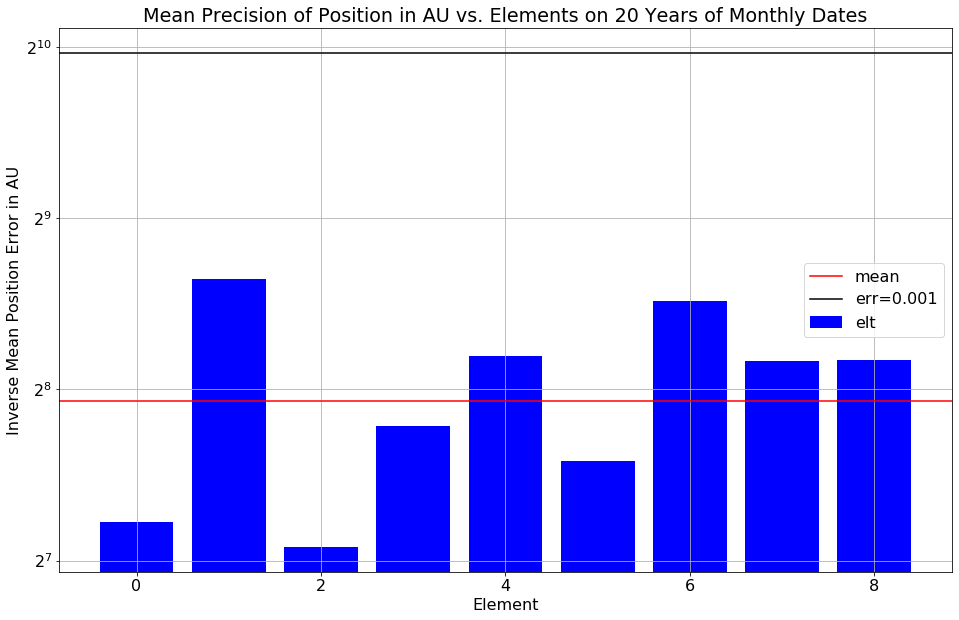

In [75]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(is_log=True, use_near_ast_dist=True)

In [76]:
fig.savefig('../figs/search_unknown/near_ast_dist.png', bbox_inches='tight')

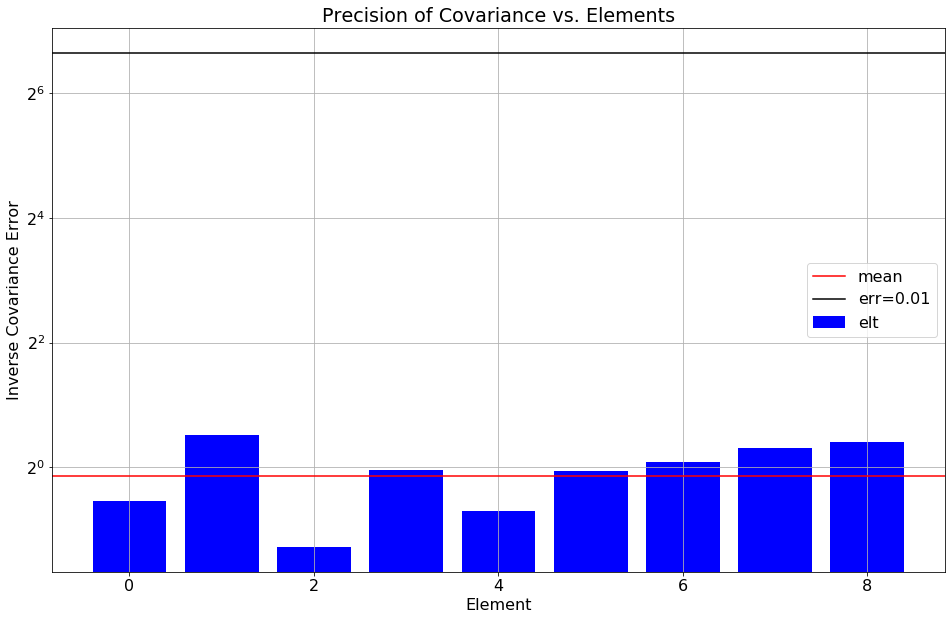

In [77]:
# Plot covariance error vs. known elements
fig, ax = model.plot_q_error(plot_type='cov', is_log=True, use_near_ast_dist=True)

In [78]:
fig.savefig('../figs/search_unknown/near_ast_cov.png', bbox_inches='tight')

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)